In [1]:
import pandas as pd 
import numpy as np
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# pip install -U scikit-learn

In [3]:
data = pd.read_csv('spam.csv')
data.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


### Data Cleaning and Prepocessing

In [6]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in ENGLISH_STOP_WORDS)
    return text

# Define the remove stop words function
def remove_stop_words(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_tokens)

# Apply the cleaning functions
data['Message'] = data['Message'].apply(clean_text).apply(remove_stop_words)

print(data.head())

  Category                                            Message  label
0      ham  jurong point crazy available bugis n great wor...    0.0
1      ham                            ok lar joking wif u oni    0.0
2     spam  free entry 2 wkly comp win fa cup final tkts 2...    1.0
3      ham                        u dun say early hor u c say    0.0
4      ham                      nah dont think goes usf lives    0.0


In [7]:
data['label'] = data['Category'].apply(lambda x: 0.0 if x == 'ham' else 1.0)
data.head()

,Category,Message,label
0,ham,jurong point crazy available bugis n great wor...,0.0
1,ham,ok lar joking wif u oni,0.0
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1.0
3,ham,u dun say early hor u c say,0.0
4,ham,nah dont think goes usf lives,0.0


### TF-IDF

In [8]:
#Need to reduce the number of features from 3000 to 100, too many features to run for PCA+GMM
X = data['Message']
y = data['label']

#The model we will need to evaluate in train, test, validation set. 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(X)
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [9]:
feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# Display the first few rows of the DataFrame
tfidf_df

,amp,ask,babe,buy,care,cash,claim,come,contact,cos,...,want,wat,way,week,went,win,won,work,yeah,yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.616585,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.575093,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.437018,0.0,0.477017,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.473208,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.543524,0.0,0.000000,0.000000,0.0,0.0,0.0


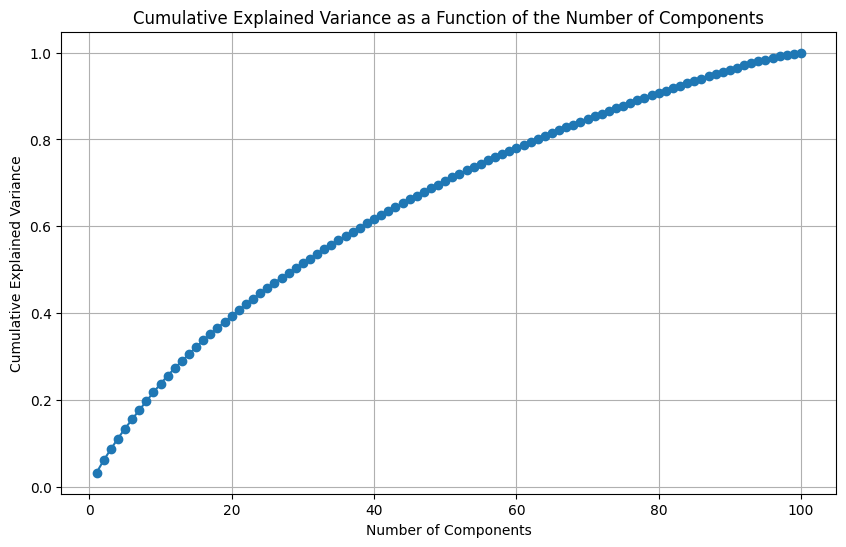

In [10]:
pca = PCA().fit(X_tfidf.toarray())

# Calculate cumulative explained variance ratio
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the elbow chart
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

Take up to PC 70 to get to 85% variance explained
Take up to PC 78 to get to 90% variance explained


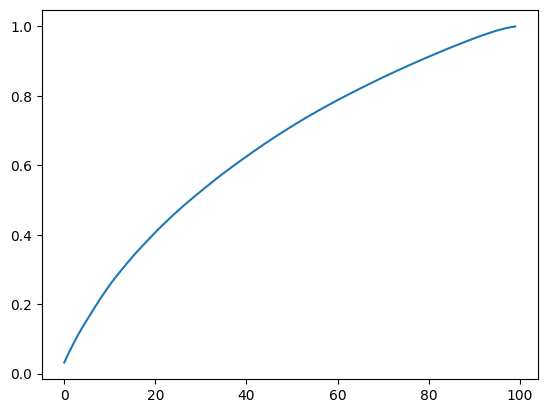

In [11]:
#Find number of PC's that account for 85% and 90% of variance
var_exp_threshs = [85, 90]

total_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.plot(total_var_exp)

for var_exp_thresh in var_exp_threshs:
    pcindex = np.where(total_var_exp >= var_exp_thresh / 100)[0]
    print(f'Take up to PC {pcindex[0]} to get to {var_exp_thresh}% variance explained')

data_pc_85 = data.iloc[:, :71]
data_pc_90 = data.iloc[:, :79]

In [12]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV

# Assuming df is your DataFrame containing 'TF-IDF Features' (already transformed) 
# and 'Label' columns, and 'PCA Components' (with 100 components) stored in the DataFrame
# Example DataFrame creation:
# df = pd.DataFrame({'TF-IDF Features': tfidf_features, 'Label': labels})

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

# Define parameters for grid search
parameters = {
    'clf__n_estimators': [50, 100, 200], # Random Forest parameters to tune
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10]
}

X_train_85, X_test_85, y_train_85, y_test_85 = train_test_split(data_pc_85['Message'], data_pc_85['label'], test_size=0.2, random_state=42)
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(data_pc_90['Message'], data_pc_90['label'], test_size=0.2, random_state=42)


# Perform grid search
grid_search_85 = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search_85.fit(X_train_85, y_train_85)

grid_search_90 = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search_90.fit(X_train_90, y_train_90)


# Print the best parameters and best score
print("Best parameters found 70 PC's:")
print(grid_search_85.best_params_)
print("Best score with 70 PC's:")
print(grid_search_85.best_score_)

print("Best parameters found 78 PC's:")
print(grid_search_90.best_params_)
print("Best score with 78 PC's:")
print(grid_search_90.best_score_)


y_pred_85 = grid_search_85.predict(X_test_85)
y_pred_90 = grid_search_90.predict(X_test_90)

# Evaluate the model
accuracy_85 = accuracy_score(y_test_85, y_pred_85)
accuracy_90 = accuracy_score(y_test_90, y_pred_90)
print("Test Accuracy with 70 PC's}:", accuracy_85)
print("\nClassification Report for 70 PC's:")
print(classification_report(y_test_85, y_pred_85))
print("Test Accuracy with 78 PC's}:", accuracy_90)
print("\nClassification Report for 78 PC's:")
print(classification_report(y_test_90, y_pred_90))


Best parameters found 70 PC's:
{'clf__max_depth': None, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}
Best score with 70 PC's:
0.9721769262128006
Best parameters found 78 PC's:
{'clf__max_depth': None, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}
Best score with 78 PC's:
0.9717277407860367
Test Accuracy with 70 PC's}: 0.9829596412556054

Classification Report for 70 PC's:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       966
         1.0       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Test Accuracy with 78 PC's}: 0.9802690582959641

Classification Report for 78 PC's:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       966
         1.0       1.00      0.85      0.92       149

    accuracy                 

In [27]:
pca = PCA(n_components=70)  # Adjust n_components based on desired variance to keep
X_pca = pca.fit_transform(X_tfidf.toarray())

# Apply GMM
gmm = GaussianMixture(n_components=2, random_state=42, covariance_type='full')  # Adjust n_components based on expected clusters
gmm.fit(X_pca)
cluster_labels = gmm.predict(X_pca)

# Add cluster labels to your dataframe
data['cluster_label'] = cluster_labels
data.head()

,Category,Message,label,cluster_label
0,ham,jurong point crazy available bugis n great wor...,0.0,1
1,ham,ok lar joking wif u oni,0.0,1
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,1.0,1
3,ham,u dun say early hor u c say,0.0,0
4,ham,nah dont think goes usf lives,0.0,0


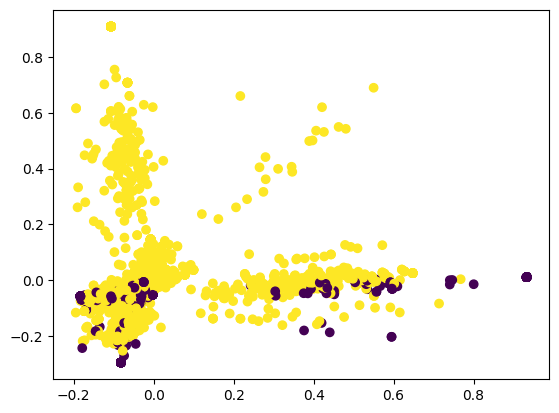

In [28]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')

In [29]:
from sklearn.metrics import adjusted_rand_score

# Assuming labels_true and labels_pred are the true labels and predicted labels, respectively
ari_score = adjusted_rand_score(data['label'], cluster_labels)

print("Adjusted Rand Index Score:", ari_score)

silhouette = silhouette_score(X_pca,cluster_labels) 
silhouette

Adjusted Rand Index Score: -0.027668908639109247


0.03580655547438982

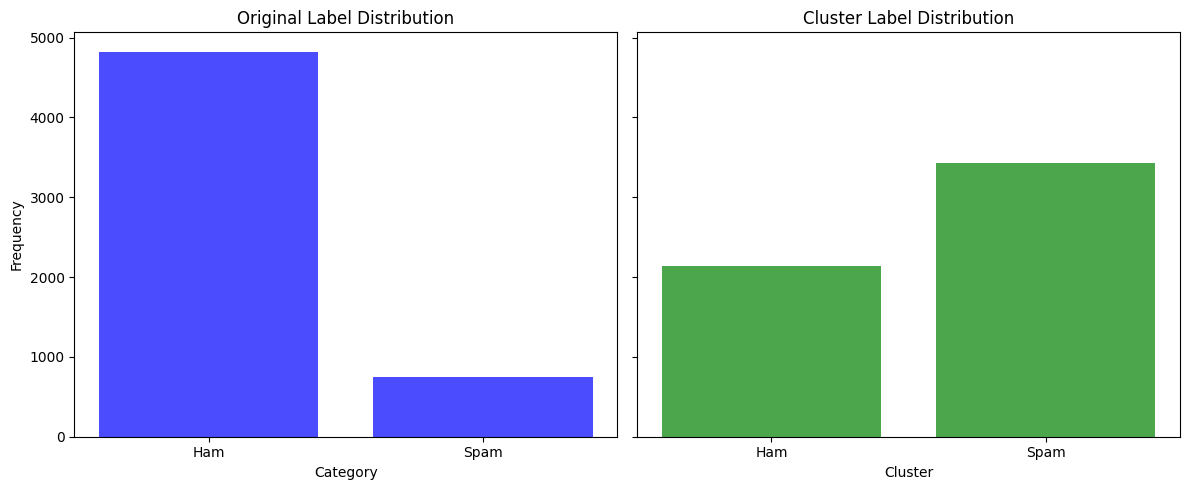

In [30]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Original Label Distribution
axes[0].hist(data['label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, color='blue', alpha=0.7)
axes[0].set_title('Original Label Distribution')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Ham', 'Spam'])
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Category')

# Cluster Label Distribution
axes[1].hist(data['cluster_label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, color='green', alpha=0.7)
axes[1].set_title('Cluster Label Distribution')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Ham', 'Spam'])
axes[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()